<a href="https://colab.research.google.com/github/rkoprik/txs_graph/blob/main/SoChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transaction data


https://chain.so/

In [ ]:
# import packages
import requests
import tabulate
import pandas as pd
import networkx as nx
import numpy as np
import datetime
 
 
# 682950 - 683238: 11/05/2021 
# 683094 - initial example
 
# range block
block_range = list(range(683093, 683200))
 
r1 = 0
r2 = 4
size_block = range(r1, r2)
 
# transaction info
transaction_id = []
input_address = []
input_value = []
output_address = []
output_value = []
date = []
date_form = []
 
# range transaction
r3 = 0
 
for y in size_block:
 
  # transaction link
  link_block = 'https://chain.so/api/v2/get_block/BTC/' + str(block_range[y])
 
  response = requests.get(link_block)
 
  if response.status_code == 200:
      # everything went swimmingly                                                                                                                   
      # parse the response as JSON
      content = response.json()
      
      # transaction id
      txs = content['data']['txs']

      # range
      r4 = len(txs)
      size = range(r3, r4)
 
  for x in size:
 
    # transaction link
    link_txs = 'https://chain.so/api/v2/tx/BTC/' + str(txs[x])
 
    response = requests.get(link_txs) 
      
    if response.status_code == 200:
          # everything went swimmingly parse the response as JSON
          content = response.json()
 
          # transaction_id
          transaction_id.append(content['data']['txid'])
          
          # input leg
          for each in content['data']['inputs']:
            input_address.append(each['address'])
            input_value.append(each['value'])
 
          # output leg
          for each in content['data']['outputs']:
            output_address.append(each['address'])
            output_value.append(each['value'])
 
          # date
          date.append(content['data']['time'])
 
          largest = max(len(transaction_id), len(input_address), len(input_value), len(output_address), len(output_value))
          
    # filling for different len
    len_transaction_id = largest - len(transaction_id)
    len_input_address = largest - len(input_address)
    len_output_address = largest - len(output_address)
    len_date = largest - len(date)
 
    corr_transaction_id = [None]*len_transaction_id
    corr_input_address = [None]*len_input_address
    corr_output_address = [None]*len_output_address
    corr_date = [None]*len_date
 
    transaction_id.extend(corr_transaction_id)
    input_address.extend(corr_input_address)
    input_value.extend(corr_input_address)
    output_address.extend(corr_output_address)
    output_value.extend(corr_output_address)
    date.extend(corr_date)
    
# as data frame 
df_01 = pd.DataFrame({'transaction_id': transaction_id, 'from': input_address, 'tt_value': input_value, 'to': output_address, 'amount': output_value, 'date': date})
 
 
#clean data
  # obmit nulldata & reindex
df= df_01[df_01.to != "nulldata"]
df.reset_index(drop=True, inplace=True)
 
 
 # fill NaN with previous data for all NaN, None
df.date = df.date.fillna(method = 'ffill')
df = df.fillna(value=np.nan)

# convert epoch time
for each in range(len(df.date)):
  date_form.append(datetime.datetime.fromtimestamp(df.date[each]).strftime('%c'))

# add date_form to df, drop old column and rename
df['date_form'] = date_form
df = df.drop(columns = 'date')
df = df.rename(columns = {'date_form': 'date'}, inplace = False)

df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,transaction_id,from,tt_value,to,amount,date
0,5904733a3b5c0762d00fa931358b07af4c7d27272f5307...,coinbase,7.29566629,bc1qx9t2l3pyny2spqpqlye8svce70nppwtaxwdrp4,7.29566629,Tue May 11 11:02:40 2021
1,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,132azVxirjmW5nQqrUHGB1jVzogHv8aWmL,0.00123653,Tue May 11 11:02:40 2021
2,NaN,NaN,NaN,3MR6fT6GT34QPMMszKDi4ALAm8cyqy2xD3,0.00284063,Tue May 11 11:02:40 2021
3,NaN,NaN,NaN,1D2Gb8EATEqS8YcMxTyi5RR5ismqQHzBsK,0.00422860,Tue May 11 11:02:40 2021
4,NaN,NaN,NaN,3AN3E6jF439iBqeyBG7CkVVWZBR88wbdNR,0.02117593,Tue May 11 11:02:40 2021
...,...,...,...,...,...,...
45211,NaN,NaN,NaN,bc1q0sgepfypaq6tvmj9e4uv3lle26z49cqsj8yewj,0.00238090,Tue May 11 11:46:04 2021
45212,a5ca2b5bd9b64a527e47204a75e5a0cc069cd28dba1847...,1P6rv1N7hk2PmfrMYFWn9rBQrMNaPCNHaw,0.00810963,3KvdMTVXdwEyqzX9rFwVrFFkE1hQRZTd3p,0.00633857,Tue May 11 11:46:04 2021
45213,NaN,NaN,NaN,36V5wTTM2P1Zd57J88deAhD7HAVjXQwYt7,0.00161000,Tue May 11 11:46:04 2021
45214,3da2a9cbaf3b94de3a99ec7659663e06491c4990e2f8dc...,3P1r5GzczAx6CxWS6GaaNic2YXJ2eWT1ts,0.00168802,187ERsNEa5wfsgJHzMVF2vR7Qa1ZcfyPmn,0.00158941,Tue May 11 11:46:04 2021


NOTE!
We need to be aware of the following different transaction types:
Newly generated coins, identifiable via the participating address "coinbase!

Indicators

In [ ]:
# Indicators

# Edge to vertex ratio
  # number of edges/number of vertices

df_counts = df.count()
#np.sum(df.count())

n_vertices = df['from'].notnull().sum() + df['to'].notnull().sum()
n_vertices

n_edges = len(txs)
n_edges

#edge-to-vertices ratio
edge_vertices_ratio = n_vertices/n_edges
edge_vertices_ratio

#input adress to output adress ration (added - not in Motamed paper)
to_from_ratio = df['to'].notnull().sum()/df['from'].notnull().sum()
to_from_ratio

#clustering coefficient


#density


#size of maximum clique


#assortativity coefficient


#repetition ratio (monthly steps)


#relative growth rate


1.4374407847071282

,amount,from,to,transaction_id,tt_value,vertices
date,,,,,,
Tue May 11 11:02:40 2021,10591,5772,10591,3306,5772,16363
Tue May 11 11:10:57 2021,7922,5969,7922,2680,5969,13891
Tue May 11 11:14:41 2021,7114,5768,7114,2274,5768,12882
Tue May 11 11:46:04 2021,9718,6199,9718,3024,6199,15917


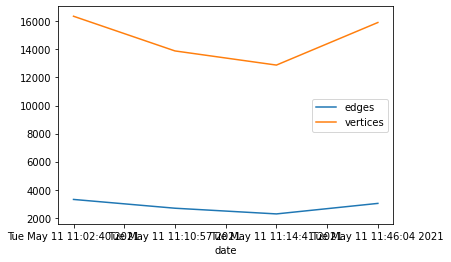

In [ ]:
import matplotlib.pyplot as plt

# summarizes df
df_solution = df.pivot_table(index=['date'], aggfunc='count')
# creates new var with vertices
df_solution['vertices'] = df_solution['to'] + df_solution['from']
# consolidated edges and vertices data 
df_egd_vert = pd.DataFrame({'edges': df_solution.transaction_id, 'vertices': df_solution.vertices})
# plot
df_egd_vert.plot()
plt.savefig('egdes_vertices.png', dpi = 300, transparent=True)
df_solution


Plotting

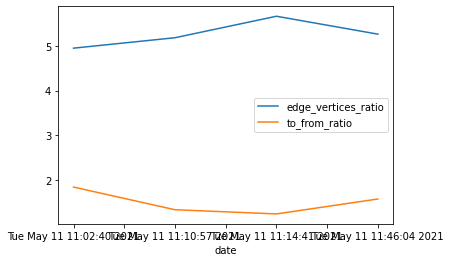

In [ ]:
# creates new col with edge to vert ratio
df_solution['edge_vertices_ratio'] = df_solution['vertices'] / df_solution['transaction_id']
# creates new col with to from ratio
df_solution['to_from_ratio'] = df_solution['to'] / df_solution['from']
# creates dataframe
df_ratios = pd.DataFrame({'edge_vertices_ratio': df_solution.edge_vertices_ratio, 'to_from_ratio': df_solution.to_from_ratio})
# plot
df_ratios.plot()
plt.savefig('ratios.png', dpi = 300, transparent=True)

In [ ]:
# density
df_solution['density'] = (2*df_solution['transaction_id']) / (df_solution['vertices']*(df_solution['vertices']-1))

# consolidated data with ratios
df_indicators = pd.DataFrame({'edges': df_solution.transaction_id, 'vertices': df_solution.vertices,
                              'edge_vertices_ratio': df_solution.edge_vertices_ratio, 'to_from_ratio': df_solution.to_from_ratio,
                              'density': df_solution.density})
df_indicators

,edges,vertices,edge_vertices_ratio,to_from_ratio,density
date,,,,,
Tue May 11 11:02:40 2021,3306,16363,4.949486,1.834893,0.000025
Tue May 11 11:10:57 2021,2680,13891,5.183209,1.327190,0.000028
Tue May 11 11:14:41 2021,2274,12882,5.664908,1.233356,0.000027
Tue May 11 11:46:04 2021,3024,15917,5.263558,1.567672,0.000024


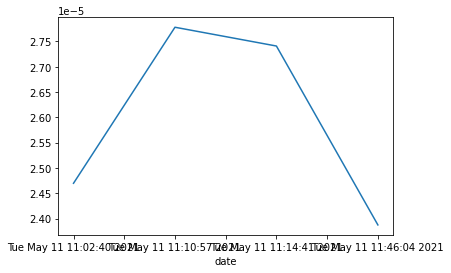

In [ ]:
df_solution.density.plot()
plt.savefig('density.png', dpi = 300, transparent=True)

In [ ]:
# nodes = vertices
import networkx as nx
# Not necessary, but will be used later:
import numpy as np 
import matplotlib.pyplot as plt 
% matplotlib inline

In [ ]:
  # Next steps
    # Get number of blocks for first for y - maybe start with a week? maybe a day?
    # Time measures for Monthly TG and Cumulative Monthly TG
    # Network measures - clustering, density, edge-to-vertex ratio, repetition, etc.

# **TESTS**

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------

# time series

# Aggregates data 
# df_solution = df.pivot_table(index=['date'], aggfunc='count')
# df_solution.plot()


# import plotly.express as px
# fig = px.histogram(df, x = 'date', y = 'transaction_id')
# fig.show()

import plotly.express as px
fig = px.line(df_indicators, x = 'date', y = 'edges')
fig.show()

In [ ]:
import plotly.express as px
fig = px.histogram(df, x = 'date', y = df['from'].notnull().sum() + df['to'].notnull().sum())
fig.show()

Create Network / Transaction graph

In [ ]:
# Network Graph
G = nx.from_pandas_edgelist(df, source='from', target='to')
nx.draw_random(G, node_size = 50)

# ------------------------------------------------------------------------------
# Jaal
  # Jaal(edge_df).plot()

          # https://towardsdatascience.com/introducing-jaal-interacting-with-network-made-easy-124173bb4fa
          # edge_df: it's a pandas dataframe with at least from and to columns, which represents the edge relationship between the entities
          # node_df: it's a pandas dataframe with at least id column which contains the unique node names     

# ------------------------------------------------------------------------------

# NetworkX         
    # https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/libraries/NetworkX.ipynb
    # https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259



In [ ]:
import pyvis
from pyvis.network import network
net = Network(notebook=True)
net.from_nx(G)
net.show("---")

In [ ]:
Denstity-based graph cluster
LetG= (V,E)be the de-temporal graph ofG;2InitializeGc= (φ,φ)as an empty graph
foreach nodeu∈Vdo
ifisStableCore(u)then
AdduintoGc
foreach unvisited nodev∈N(u)do
  ifS(u,v)has not been computedthen
  ComputeS(u,v)and store it
ifS(u,v)≥τthen
ifisStableCore(v)then
Add nodevand edge(u,v)intoGc
Markuas a visited node
C←the set of connected components inGc
C ←{C∪u∈CN(τ,)(u)|C∈C}; //cluster non-core nodes
returnC
ProcedureComputeS(u,v)
S(u,v)←0
fori←1 :Tdo
HashSet←∅
fornodewin{Ni(u)∪Ni(v)}do
ifHashSet.has(w)thenHashSet.w+ +
elseHashSet.w←0
|Ni(u)|∩|Ni(v)|←#wsatisfyingHashSet.w >0
ifthere is an temporal edge(u,v,t)such thatt∈(ti−1,ti]then
ifσi(u,v)≥thenS(u,v)←S(u,v) + 1
ifS(u,v)≥τthen break
returnS(u,v);

ALTERNATIVE FORMAT FOR NETWORKX

In [ ]:
# same import code - different final format

# import packages
import requests
import tabulate
import pandas as pd
import networkx as nx
import numpy as np
import datetime
 
 
# 682950 - 683238: 11/05/2021 
# 683094 - initial example
 
# range block
block_range = list(range(683093, 683100))
 
r1 = 0
r2 = 4
size_block = range(r1, r2)
 
# transaction info
transaction_id = []
input_address = []
input_value = []
output_address = []
output_value = []
date = []
date_form = []
 
# range transaction
r3 = 0
 
for y in size_block:
 
  # transaction link
  link_block = 'https://chain.so/api/v2/get_block/BTC/' + str(block_range[y])
 
  response = requests.get(link_block)
 
  if response.status_code == 200:
      # everything went swimmingly                                                                                                                   
      # parse the response as JSON
      content = response.json()
      
      # transaction id
      txs = content['data']['txs']

      # range
      r4 = 10
      # len(txs)
      size = range(r3, r4)
 
  for x in size:
 
    # transaction link
    link_txs = 'https://chain.so/api/v2/tx/BTC/' + str(txs[x])
 
    response = requests.get(link_txs) 
      
    if response.status_code == 200:
          # everything went swimmingly parse the response as JSON
          content = response.json()
 
          # transaction_id
          transaction_id.append(content['data']['txid'])
          
          # input leg
          for each in content['data']['inputs']:
            input_address.append(each['address'])
            input_value.append(each['value'])
 
          # output leg
          for each in content['data']['outputs']:
            output_address.append(each['address'])
            output_value.append(each['value'])
 
          # date
          date.append(content['data']['time'])
 
          largest = max(len(transaction_id), len(input_address), len(input_value), len(output_address), len(output_value))
          
    # filling for different len
    len_transaction_id = largest - len(transaction_id)
    len_input_address = largest - len(input_address)
    len_output_address = largest - len(output_address)
    len_date = largest - len(date)

    corr_transaction_id = [None]*len_transaction_id
    corr_input_address = [None]*len_input_address
    corr_output_address = [None]*len_output_address
    corr_date = [None]*len_date
 
    transaction_id.extend(corr_transaction_id)
    input_address.extend(corr_input_address)
    input_value.extend(corr_input_address)
    output_address.extend(corr_output_address)
    output_value.extend(corr_output_address)
    date.extend(corr_date)
    
# as data frame 
df_01 = pd.DataFrame({'transaction_id': transaction_id, 'from_leg': input_address, 'tt_value': input_value, 'to': output_address, 'amount': output_value, 'date': date})
 
 
#clean data
  # obmit nulldata & reindex
df= df_01[df_01.to != "nulldata"]
df.reset_index(drop=True, inplace=True)
 
 
 # fill NaN with previous data for all NaN, None
df.date = df.date.fillna(method = 'ffill')
df.from_leg = df.from_leg.fillna(method = 'ffill')
df.transaction_id = df.transaction_id.fillna(method = 'ffill')
df.tt_value = df.tt_value.fillna(method = 'ffill')
df = df.fillna(value=np.nan)

# convert epoch time
for each in range(len(df.date)):
  date_form.append(datetime.datetime.fromtimestamp(df.date[each]).strftime('%c'))

# add date_form to df, drop old column and rename
df['date_form'] = date_form
df = df.drop(columns = 'date')
df = df.rename(columns = {'date_form': 'date'}, inplace = False)


df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,transaction_id,from_leg,tt_value,to,amount,date
0,5904733a3b5c0762d00fa931358b07af4c7d27272f5307...,coinbase,7.29566629,bc1qx9t2l3pyny2spqpqlye8svce70nppwtaxwdrp4,7.29566629,Tue May 11 11:02:40 2021
1,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,132azVxirjmW5nQqrUHGB1jVzogHv8aWmL,0.00123653,Tue May 11 11:02:40 2021
2,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,3MR6fT6GT34QPMMszKDi4ALAm8cyqy2xD3,0.00284063,Tue May 11 11:02:40 2021
3,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,1D2Gb8EATEqS8YcMxTyi5RR5ismqQHzBsK,0.00422860,Tue May 11 11:02:40 2021
4,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,3AN3E6jF439iBqeyBG7CkVVWZBR88wbdNR,0.02117593,Tue May 11 11:02:40 2021
...,...,...,...,...,...,...
86,9d34c72f7b4d0f456af03895fc5a0bc943d072e9c7ab85...,1K6htKt2FcviPWGJVAKTPrdacVynWBak2y,1.38197239,1NoRDzt5qmk4pqnfRq7iySsAgMGbUrKv8U,0.00029472,Tue May 11 11:46:04 2021
87,9d34c72f7b4d0f456af03895fc5a0bc943d072e9c7ab85...,1K6htKt2FcviPWGJVAKTPrdacVynWBak2y,1.38197239,1JAHWCTvR6RkekFbqHGomABMcPDXEsYTHf,0.03070796,Tue May 11 11:46:04 2021
88,9d34c72f7b4d0f456af03895fc5a0bc943d072e9c7ab85...,1K6htKt2FcviPWGJVAKTPrdacVynWBak2y,1.38197239,3LeptGksFp1W8RUb8zwxXEFaam4wJcMQqm,0.01000000,Tue May 11 11:46:04 2021
89,9d34c72f7b4d0f456af03895fc5a0bc943d072e9c7ab85...,1K6htKt2FcviPWGJVAKTPrdacVynWBak2y,1.38197239,1JUwvdixdCoqhMsyVbYGYLzGzZP6z7AH4F,1.31212603,Tue May 11 11:46:04 2021


In [ ]:
# Prep for NetworkX

# creates tuple list
d = list(df.from_leg)
e = list(df.to)
list_of_edges = []
list_of_nodes = list(df.transaction_id)
# tuple
lst_tuple = list(zip(d,e))

# create an empty graph
g = nx.Graph()

# adds edges
g.add_edges_from(lst_tuple)
print(g.edges())
print(g.nodes())


# plots
# nx.draw_kamada_kawai(g, with_labels=False)    

[('coinbase', 'bc1qx9t2l3pyny2spqpqlye8svce70nppwtaxwdrp4'), ('coinbase', '1Bf9sZvBHPFGVPX71WX2njhd1NXKv5y7v5'), ('coinbase', '1E6vTBe9KLCh5ZqEkLoV2Fh5syXVHxHkna'), ('coinbase', '18cBEMRxXHqzWWCxZNtU91F5sbUNKhL5PX'), ('bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar', '132azVxirjmW5nQqrUHGB1jVzogHv8aWmL'), ('bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar', '3MR6fT6GT34QPMMszKDi4ALAm8cyqy2xD3'), ('bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar', '1D2Gb8EATEqS8YcMxTyi5RR5ismqQHzBsK'), ('bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar', '3AN3E6jF439iBqeyBG7CkVVWZBR88wbdNR'), ('bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar', 'bc1qf00j492k6y800lr4wdtmfxsuxxnq9gvu8lex7a'), ('bc1qu3l4q0fcdhrucf4y658dnlf0x5404pmp3nk8kp', '157FJp1aMEyvdYGtfQ3LHEmbvwq5o5aW2t'), ('bc1qu3l4q0fcdhrucf4y658dnlf0x5404pmp3nk8kp', '35GD6Byj7M3br57SHFcQYGXHVkyXHpHLc2'), ('bc1qu3l4q0fcdhrucf4y658dnlf0x5404pmp3nk8kp', '3PgiSaF5jvpr9VughJJWdw9yAumHdmPL7M'), ('bc1qu3l4q0fcdhrucf4y658dnlf0x5404pmp3nk8kp', 'bc1q6q7ctzv3qxdyt2p80x83kgykkct6gkr452h

In [ ]:
# Get information on the graph level
  # https://claudius-graebner.com/teaching/20_01-Cusanus19/Networks.html

# Number of vertices
g.number_of_nodes()
nodes_summary = nx.number_of_nodes(g)

# Number of edges
g.number_of_edges()
edges_summary = nx.number_of_edges(g)

# Connectedness
  # A graph is connected if every node can be reached from any other node
connection_summary = nx.is_connected(g)

# Diameter
  # longest distance between two vertices
# nx.diameter(g)
  # NetworkXError: Found infinite path length because the graph is not connected

# Average path length
  # average of all the distances in the graph
# nx.average_shortest_path_length(g)
  # NetworkXError: Graph is not connected.

# Density
density_summary = nx.density(g)

# Transitivity
  # relating the number of triangles with the number of triples in the graph
transitivity_summary = nx.transitivity(g)

# Clustering coefficient
clustering_summary = nx.average_clustering(g)

# Average degree
  # average of all vertex degrees in the graph
avgdegree_summary = np.mean([i[1] for i in g.degree()])

# summary table
summary = pd.DataFrame({'Number of vertices': nodes_summary, 
                        'Number of edges': edges_summary, 
                        'Connectedness': connection_summary, 
                        'Density': density_summary, 
                        'Transitivity': transitivity_summary, 
                        'Clustering': clustering_summary,
                        'Average degree': avgdegree_summary}, index=[0])
summary

,Number of vertices,Number of edges,Connectedness,Density,Transitivity,Clustering,Average degree
0,104,84,False,0.015683,0.031579,0.020192,1.615385


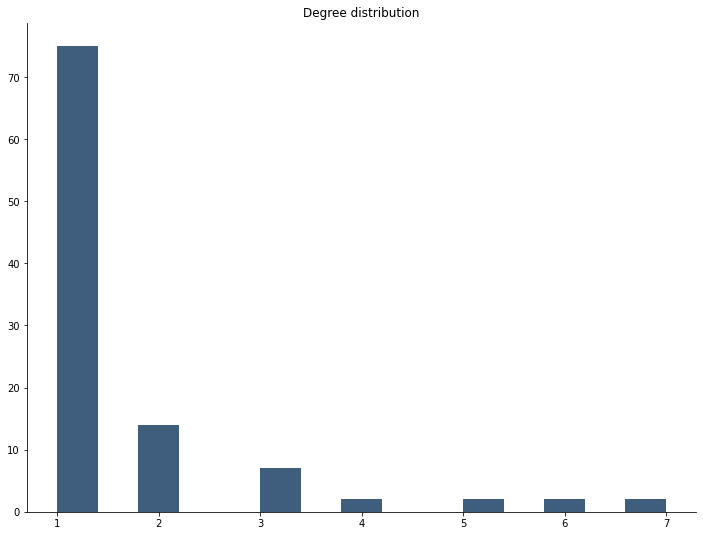

In [ ]:
# Degree distribution
  #  degree of a node in a network is the number of connections it has to other 
  # nodes and the degree distribution is the probability distribution of these 
  # degrees over the whole network.
degs = [i[1] for i in g.degree()]
fig, ax = plt.subplots(figsize=(12, 9))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.set_title("Degree distribution") # title

ax.hist(degs, color="#3F5D7D", bins='auto');

plt.savefig('degree_dist.png', dpi = 300, transparent=True)
  # only very few vertices with high degrees, and many with relatively small degrees 
  # -- a typical results for social networks. In such cases, we say that the degree 
  # distribution is heavy tailed.

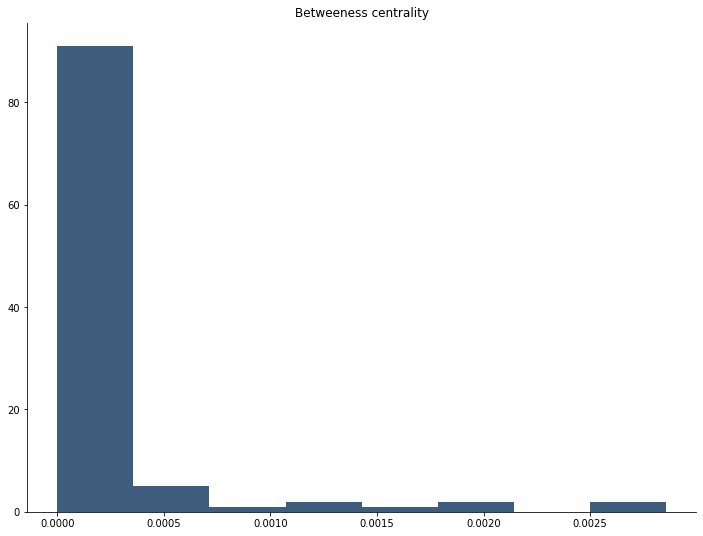

In [ ]:
# Betweeness Centrality
  # a vertex is important when it connects two large communities, which would 
  # remain unconnected if the vertex was not there.
  
between_centralities = nx.betweenness_centrality(g).values()

fig, ax = plt.subplots(figsize=(12, 9))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.set_title("Betweeness centrality")

ax.hist(between_centralities, color="#3F5D7D", bins='auto');

plt.savefig('betweeness.png', dpi = 300, transparent=True)

In [ ]:
# Get information on the vertex level

# Neighborhood
  # neighborhood of vertex  vi  is the set of all vertices that are adjacent to  vi
nx.all_neighbors(g, "bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar")

# Connectedness
  # Two vertices are connected of there is a path between then
nx.has_path(g, "bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar", "coinbase")

# Distance between two vertices
  # In an unweighted graph, the distance between two vertices is the length of 
  # the shortest path between them. In a weighted graph, it is usually the sum of the edge weights between the two vertices.
# nx.shortest_path(g, "bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar", "1HiPiS3UBYxZPbM8qgr7gmEyVDuuZCzXVA")
  # NetworkXNoPath: No path between bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar and 1HiPiS3UBYxZPbM8qgr7gmEyVDuuZCzXVA.

# Clustering coefficient
  # The clustering coefficient of a single vertex informs us about how well the 
  # neighbors of the vertex are themselves connected. The maximum amount of 
  # clustering is achieved if all neighbors of the vertex are neighbores as well
nx.clustering(g, "bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar")

# Degree 
  # The degree of  vi  is just the number of adjacent vertices.
g.degree("bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar")

# Eigenvector Centrality
  # The centrality of a vertex measures its structural importance
  # the connection to a vertex that has many degrees counts more than a 
  # connection to a vertex with few connections. This logic leads to the concept 
  # of eigenvector centrality because the recursive calculation of importance can 
  # be expressed as the problem of finding an eigenvector.

# eigen_centralities = nx.eigenvector_centrality(g).values()

# fig, ax = plt.subplots(figsize=(12, 9))
# ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
# ax.spines["right"].set_visible(False) # Remove plot frame line on the right
# ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
# ax.get_yaxis().tick_left()  # Remove the ticks on the left
# ax.set_title("Eigenvector centrality")

# ax.hist(eigen_centralities, color="#3F5D7D", bins='auto');
  # 'power iteration failed to converge within 100 iterations')




# Network graph - prettier
# 

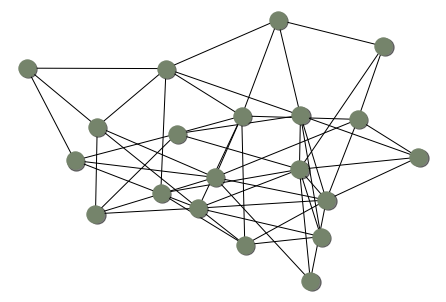

In [ ]:
# Network graph 1
import copy
import networkx
import matplotlib.pyplot as plt

# Generate a graph.
# Here I chose an ER graph.
g = nx.erdos_renyi_graph(20, 0.3)

# Get positions.
# Here I use the spectral layout and add a little bit of noise.
pos = nx.layout.spectral_layout(g)
pos = nx.spring_layout(g, pos=pos, iterations=50)

# Create position copies for shadows, and shift shadows
pos_shadow = copy.deepcopy(pos)
shift_amount = 0.006
for idx in pos_shadow:
    pos_shadow[idx][0] += shift_amount
    pos_shadow[idx][1] -= shift_amount

#~~~~~~~~~~~~
# Draw graph
#~~~~~~~~~~~~
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

nx.draw_networkx_nodes(g, pos_shadow, node_color='k', alpha=0.5)
nx.draw_networkx_nodes(g, pos, node_color="#75846b", linewidths=1)
nx.draw_networkx_edges(g, pos, width=1)



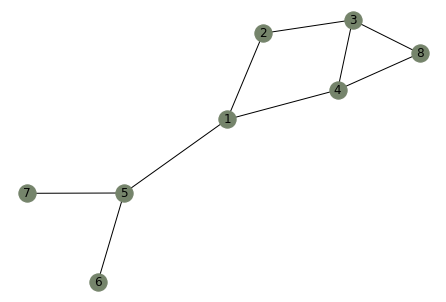

In [ ]:
# Network graph 2

import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
  
g = nx.Graph()
  
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 4)
g.add_edge(1, 4)
g.add_edge(1, 5)
g.add_edge(5, 6)
g.add_edge(5, 7)
g.add_edge(4, 8)
g.add_edge(3, 8)
  
# drawing in spring layout
nx.draw_spring(g, with_labels = True, node_color="#75846b")
plt.savefig("tg.png", transparent = True, dpi = 300)

**BACKUP**

In [ ]:
# import packages
import requests
import tabulate
import pandas as pd
import networkx as nx
import numpy as np
 
 
# 682950 - 683238: 11/05/2021 
# 683094 - initial example
 
# range block
block_range = list(range(683093, 683098))
 
r1 = 0
r2 = 1
size_block = range(r1, r2)
 
# transaction info
transaction_id = []
input_address = []
input_value = []
output_address = []
output_value = []
date = []
 
# range transaction
r3 = 0
r4 = 10
# len(txs)
size = range(r3, r4)
 
for y in size_block:
 
  # transaction link
  link_block = 'https://chain.so/api/v2/get_block/BTC/' + str(block_range[y])
 
  response = requests.get(link_block)
 
  if response.status_code == 200:
      # everything went swimmingly                                                                                                                   
      # parse the response as JSON
      content = response.json()
      
      # transaction id
      txs = content['data']['txs']
 
  for x in size:
 
    # transaction link
    link_txs = 'https://chain.so/api/v2/tx/BTC/' + str(txs[x])
 
    response = requests.get(link_txs)
 
      
    if response.status_code == 200:
          # everything went swimmingly parse the response as JSON
          content = response.json()
 
          # transaction_id
          transaction_id.append(content['data']['txid'])
          
          # input leg
          for each in content['data']['inputs']:
            input_address.append(each['address'])
            input_value.append(each['value'])
 
          # output leg
          for each in content['data']['outputs']:
            output_address.append(each['address'])
            output_value.append(each['value'])
 
          # date
          date.append(content['data']['time'])
 
          largest = max(len(transaction_id), len(input_address), len(input_value), len(output_address), len(output_value))
          
    # filling for different len
    len_transaction_id = largest - len(transaction_id)
    len_input_address = largest - len(input_address)
    len_output_address = largest - len(output_address)
    len_date = largest - len(date)
 
    corr_transaction_id = [None]*len_transaction_id
    corr_input_address = [None]*len_input_address
    corr_output_address = [None]*len_output_address
    corr_date = [None]*len_date
 
    transaction_id.extend(corr_transaction_id)
    input_address.extend(corr_input_address)
    input_value.extend(corr_input_address)
    output_address.extend(corr_output_address)
    output_value.extend(corr_output_address)
    date.extend(corr_date)
    
# as data frame 
df_01 = pd.DataFrame({'transaction_id': transaction_id, 'from': input_address, 'tt_value': input_value, 'to': output_address, 'amount': output_value, 'date': date})
 
 
#clean data
  # obmit nulldata & reindex
df= df_01[df_01.to != "nulldata"]
df.reset_index(drop=True, inplace=True)
 
 
 # fill NaN with previous data for all NaN, None
df.date = df.date.fillna(method = 'ffill')
df = df.fillna(value=np.nan)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,transaction_id,from,tt_value,to,amount,date
0,5904733a3b5c0762d00fa931358b07af4c7d27272f5307...,coinbase,7.29566629,bc1qx9t2l3pyny2spqpqlye8svce70nppwtaxwdrp4,7.29566629,1.620731e+09
1,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,132azVxirjmW5nQqrUHGB1jVzogHv8aWmL,0.00123653,1.620731e+09
2,NaN,NaN,NaN,3MR6fT6GT34QPMMszKDi4ALAm8cyqy2xD3,0.00284063,1.620731e+09
3,NaN,NaN,NaN,1D2Gb8EATEqS8YcMxTyi5RR5ismqQHzBsK,0.00422860,1.620731e+09
4,NaN,NaN,NaN,3AN3E6jF439iBqeyBG7CkVVWZBR88wbdNR,0.02117593,1.620731e+09
5,NaN,NaN,NaN,bc1qf00j492k6y800lr4wdtmfxsuxxnq9gvu8lex7a,0.91419917,1.620731e+09
6,431766a0a6a117f3f41777cf3a60901e633c070bb08913...,bc1qu3l4q0fcdhrucf4y658dnlf0x5404pmp3nk8kp,8.20975695,157FJp1aMEyvdYGtfQ3LHEmbvwq5o5aW2t,0.00019787,1.620731e+09
7,NaN,NaN,NaN,35GD6Byj7M3br57SHFcQYGXHVkyXHpHLc2,0.00911332,1.620731e+09
8,NaN,NaN,NaN,3PgiSaF5jvpr9VughJJWdw9yAumHdmPL7M,0.01000000,1.620731e+09
9,NaN,NaN,NaN,bc1q6q7ctzv3qxdyt2p80x83kgykkct6gkr452hht4,8.18933576,1.620731e+09
